<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/rnn/music_generation_chord_duration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install -Uqq bs4
!pip install -Uqq music21
!pip install -Uqq tensorflow-addons
!pip install -Uqq "tqdm>=4.36.1"

     |████████████████████████████████| 1.1MB 14.2MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 


In [2]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get -qq update
!apt-get -qq install musescore
!apt-get -qq install xvfb
!sh -e /etc/init.d/x11-common start
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset


Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/mscore-ubuntu/mscore-stable/ubuntu bionic InRelease [15.4 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubu

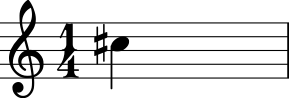

In [3]:
import os
from music21 import *

os.putenv('DISPLAY', ':99.0')
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'
n = note.Note('C#5')
n.show()

In [61]:
import time
import os
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from pathlib import Path
from urllib.request import urlopen
from urllib.request import urlretrieve
from bs4 import BeautifulSoup
from music21 import converter
from music21 import instrument
from tqdm import tqdm

In [5]:
DATASET_PATH = Path('dataset/')
try:
  os.mkdir(DATASET_PATH)
except FileExistsError:
  # dataset directory already exists
  pass

In [6]:
url0 = 'https://www.mutopiaproject.org/cgibin/make-table.cgi?startat='
url_query_p1 = '&searchingfor=&Composer=&Instrument=Guitar&Style=&collection='
url_query_p2 = '&id=&solo=&recent=&timelength=&timeunit=&lilyversion=&preview='
url1 = url_query_p1 + url_query_p2

In [7]:
song_number = 0
link_count = 10

while link_count > 0:
  url = f'{url0}{song_number}{url1}'
  html = urlopen(url)
  soup = BeautifulSoup(html.read())
  links = soup.find_all('a')
  link_count = 0
  for link in links:
    href = link['href']
    if href.find('.mid') >= 0:
      link_count += 1
      file_name = os.path.basename(href)
      urlretrieve(href, DATASET_PATH/file_name)
  song_number += 10
  time.sleep(1.0)
  

## Discrete Music Representation

### Notes

A **note** is a symbolic representation of a sound. For our purposes, a `note` can be `described by` its `pitch` and `duration`. A note's **pitch** is related to the frequency of oscillation of its sound wave, which is measured in hertz (Hz). Notes with higher pitches have sound waves with more oscillations per second. A note's duration is the length of the period over which it is played.

**MIDI files** represent a note's pitch with an integer between 0 and 127. Notes may also be represented by a pitch letter and octave number. Within the same octave, the pitches are ordered from lowest to highest frequency as follows:

lowest | to | highests
--- | --- | ---
1. C | 5. E R | 9. Ab/G#
2. C#/Db | 6. F | 10.A
3. D | 7. F#/Gb | 11.Bb/A#
4. Eb/D# | 8. G | 12. B

The **octave** is indicated by a subscript, such as the 4 in $A_4$ or the 7 in $C_7$. A higher octave corresponds to a higher frequency. If we take an arbitrary pitch, $X_i$, then the pitch $X_{i+1}$, which is exactly one octave higher, represents a sound wave with twice the frequency of $X_i$.

In addition to a note's pitch, we will also make use of its duration. The duration is a relative value, which is normalized by the length of a whole note. The longest note is a "large" note, which is eight times as long as a whole note. The shortest note is a two hundred fifty-sixth note, which is 1/256th the length of a whole note.

### Chords

A **chord** is a combination of two or more notes played simultaneously on the same instrument. If we look at monophonic music -- that is, music played on a single instrument -- we may identify chords by assuming that all notes played at the exact same time are part of the same chord. This assumption is not valid if we have polyphonic music, which consists of two or more instruments playing simultaneously.

In the code block below, we install music21 and then import the converter module, which we will use to parse MIDI files. We will load and parse a classical guitar piece by Mauro Giuliani. We will then apply the .chordify() method, which reconstructs the sequence of chords in the score, assuming that notes played simultaneously are part of the same chord.

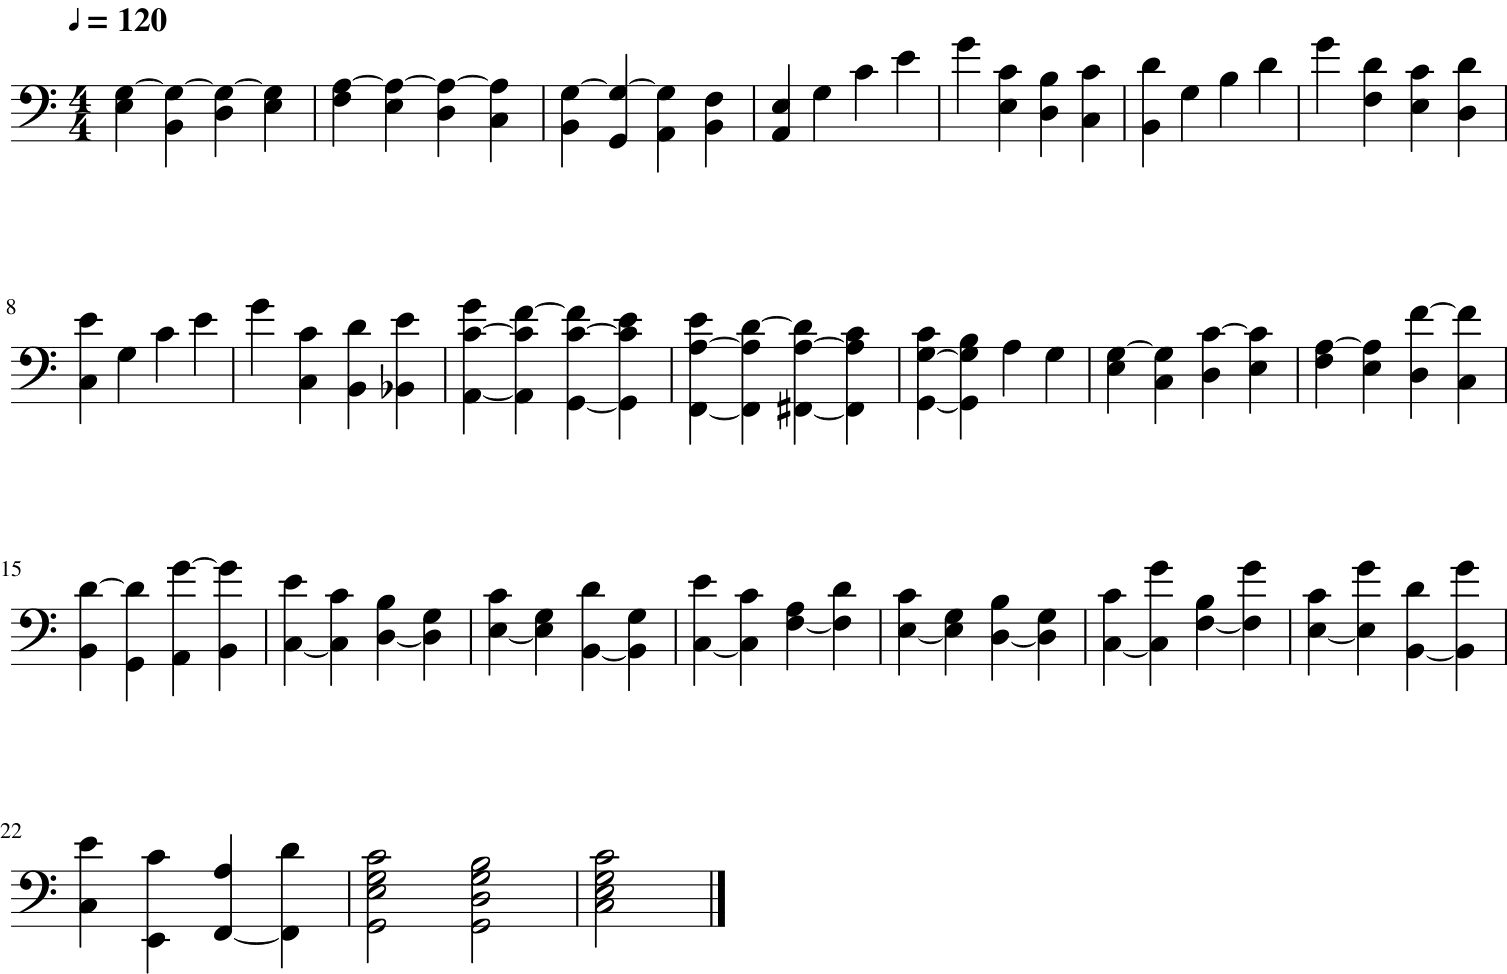

In [8]:
score = converter.parse(DATASET_PATH/'giuliani-o51-01.mid').chordify()
score.show()

In [9]:
score.show('text')

{0.0} <music21.instrument.Guitar 'Guitar'>
{0.0} <music21.instrument.Instrument ''>
{0.0} <music21.instrument.AcousticGuitar 'acoustic guitar (nylon)'>
{0.0} <music21.instrument.Guitar 'Guitar'>
{0.0} <music21.tempo.MetronomeMark animato Quarter=120.0>
{0.0} <music21.key.Key of C major>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.chord.Chord E3 G3>
{1.0} <music21.chord.Chord B2 G3>
{2.0} <music21.chord.Chord D3 G3>
{3.0} <music21.chord.Chord E3 G3>
{4.0} <music21.chord.Chord F3 A3>
{5.0} <music21.chord.Chord E3 A3>
{6.0} <music21.chord.Chord D3 A3>
{7.0} <music21.chord.Chord C3 A3>
{8.0} <music21.chord.Chord B2 G3>
{9.0} <music21.chord.Chord G2 G3>
{10.0} <music21.chord.Chord A2 G3>
{11.0} <music21.chord.Chord B2 F3>
{12.0} <music21.chord.Chord A2 E3>
{13.0} <music21.chord.Chord G3>
{14.0} <music21.chord.Chord C4>
{15.0} <music21.chord.Chord E4>
{16.0} <music21.chord.Chord G4>
{17.0} <music21.chord.Chord E3 C4>
{18.0} <music21.chord.Chord D3 B3>
{19.0} <music21.chord.Chord C

In [10]:
score.elements[10]

<music21.chord.Chord E3 G3>

In [11]:
score.elements[10].duration

<music21.duration.Duration 1.0>

In [12]:
song_list = os.listdir(DATASET_PATH)

original_scores = [converter.parse(DATASET_PATH/song) 
                    for song in song_list if song.lower().find('giuliani') > -1]
print('Total <giuliani> songs found:',len(original_scores))

Total <giuliani> songs found: 88


In [13]:
def monophonic(stream):
  try:
    length = len(instrument.partitionByInstrument(stream).parts)
  except:
    length = 0
  return length == 1

In [14]:
monophonic_scores = [song.chordify() 
                      for song in original_scores if monophonic(song)]
print('Monophonic songs:', len(monophonic_scores))

Monophonic songs: 32


In [15]:
def extract_chords(song):
  chords = []
  for element in song:
    if isinstance(element, note.Note):
      chords.append(element.pitch)
    elif isinstance(element, chord.Chord):
      chords.append('.'.join(str(p) for p in element.pitches))
  return chords

In [16]:
def extract_durations(song):
  durations = []
  for element in song:
    if isinstance(element, note.Note) or isinstance(element, chord.Chord):
      durations.append(element.duration.quarterLength)
  return durations

In [17]:
monophonic_keys = [str(song.analyze('key')) for song in monophonic_scores]
monophonic_chords = [extract_chords(song) for song in monophonic_scores]
monophonic_durations = [extract_durations(song) for song in monophonic_scores]

In [18]:
c_major_chords = [c for c, k in zip(monophonic_chords, monophonic_keys) 
                  if k == 'C major']
c_major_durations = [d for d, k in zip(monophonic_durations, monophonic_keys) 
                  if k == 'C major']

In [19]:
unique_chords = set([c for chords in c_major_chords for c in chords])
chord_to_int = dict(zip(unique_chords, list(range(0, len(unique_chords)))))
int_to_chord = {i: c for c, i in chord_to_int.items()}

unique_durations = set([d for ds in c_major_durations for d in ds])
duration_to_int = dict(zip(unique_durations, list(range(0, len(unique_durations)))))
int_to_duration = {i: d for d, i in duration_to_int.items()}

print('Unique chords', len(unique_chords))
print('Unique durations', len(unique_durations))

Unique chords 139
Unique durations 10


In [20]:
CHORD_VOCAB_SIZE = len(unique_chords)
DURATION_VOCAB_SIZE = len(unique_durations)
EMBEDDING_SIZE = 64
LSTM_MEMORY_UNITS = 512
DENSE_SIZE = 256
BATCH_SIZE = 4
SEQUENCE_LENGTH = 32

In [21]:
#concatenated_songs_chords = np.concatenate(c_major_chords)
concatenated_songs_chords = np.array([chord_to_int[chord] for song in c_major_chords for chord in song])
concatenated_songs_durations = np.array([duration_to_int[duration] for song in c_major_durations for duration in song])
print('Concatenated songs chords shape:', concatenated_songs_chords.shape)
print('Concatenated songs durations shape:', concatenated_songs_durations.shape) 

Concatenated songs chords shape: (1571,)
Concatenated songs durations shape: (1571,)


In [22]:
def get_batch(vectorized_songs, seq_length, batch_size):
  # length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1

  # randomly choose the starting indices for the examples in the training
  idx = np.random.choice(n - seq_length, batch_size)

  input_batch = [vectorized_songs[s: s + seq_length] 
                 for _, s in enumerate(idx)]

  output_batch = [vectorized_songs[s + 1: s + 1 + seq_length] 
                  for _, s in enumerate(idx)]
  
  X_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return X_batch, y_batch

# get_batch "unit test"
test_batch_size = 3
test_sequence_length = 5
fake_concatenated_songs = np.random.randint(1, 100, 100)
X_test_batch, y_test_batch = get_batch(
    fake_concatenated_songs, test_sequence_length, test_batch_size
)
assert X_test_batch.shape == (test_batch_size, test_sequence_length)

X_test_batch, y_test_batch = get_batch(
    concatenated_songs_chords, test_sequence_length, test_batch_size
)
assert X_test_batch.shape == (test_batch_size, test_sequence_length)


In [23]:
chord_input = Input(shape=(SEQUENCE_LENGTH,), batch_size=BATCH_SIZE, name='chord_input')

duration_input = Input(shape=(SEQUENCE_LENGTH,), batch_size=BATCH_SIZE, name='duration_input')

chord_embedding = Embedding(CHORD_VOCAB_SIZE, EMBEDDING_SIZE)(chord_input)

duration_embedding = Embedding(
    DURATION_VOCAB_SIZE,
    EMBEDDING_SIZE
)(duration_input)

merge_layer = Concatenate(axis=-1)([chord_embedding, duration_embedding])

lstm_layer = LSTM(
    LSTM_MEMORY_UNITS,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    stateful=False  # should be True???
)(merge_layer)


dense_layer = Dense(DENSE_SIZE)(lstm_layer)

chord_output = Dense(CHORD_VOCAB_SIZE, name='chord_output')(dense_layer)

duration_output = Dense(DURATION_VOCAB_SIZE, name='duration_output')(dense_layer)

lstm = Model(
    inputs = [chord_input, duration_input], 
    outputs = [chord_output, duration_output]
)

In [24]:
lstm.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
chord_input (InputLayer)        [(4, 32)]            0                                            
__________________________________________________________________________________________________
duration_input (InputLayer)     [(4, 32)]            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (4, 32, 64)          8896        chord_input[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embedding)         (4, 32, 64)          640         duration_input[0][0]             
_______________________________________________________________________________________

In [25]:
X_chords, y_chords = get_batch(concatenated_songs_chords, SEQUENCE_LENGTH, BATCH_SIZE * 1000)
X_durations, y_durations = get_batch(concatenated_songs_durations, SEQUENCE_LENGTH, BATCH_SIZE * 1000)
y_chords_pred, y_durations_pred = lstm([X_chords, X_durations], [y_chords, y_durations])
y_chords_pred.shape, y_durations_pred.shape

(TensorShape([4000, 32, 139]), TensorShape([4000, 32, 10]))

In [26]:
for i, (input_idx, target_idx) in enumerate(zip(X_chords[0][:3], y_chords[0][:3])):
  print('Step:', i)
  print(f'input: {input_idx} ({int_to_chord[input_idx]})')
  print(f'expected output: {target_idx} ({int_to_chord[target_idx]})')

Step: 0
input: 126 (G4.G5)
expected output: 126 (G4.G5)
Step: 1
input: 126 (G4.G5)
expected output: 127 (D4.F5)
Step: 2
input: 127 (D4.F5)
expected output: 35 (G4.F5)


In [27]:
def compute_loss(labels, logits):
  loss = SparseCategoricalCrossentropy(from_logits=True)
  return loss(labels, logits)

In [28]:
loss_chords = compute_loss(y_chords, y_chords_pred)
loss_durations = compute_loss(y_durations, y_durations_pred)

loss_chords.numpy(), loss_durations.numpy()

(4.933799, 2.3010147)

In [62]:
lstm.compile(
    optimizer='rmsprop',
    loss={
        'chord_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        'duration_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    },
    metrics=['accuracy']
)

In [63]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

history = lstm.fit(
    {'chord_input': X_chords, 'duration_input': X_durations},
    {'chord_output': y_chords, 'duration_output': y_durations},
    epochs=100,
    batch_size=4,
    callbacks=[tqdm_callback],
)

Epoch 1/100


Epoch 1/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1542 - chord_output_loss: 0.1160 - duration_output_loss: 0.0382 - chord_output_accuracy: 0.9607 - duration_output_accuracy: 0.9867
Epoch 2/100


Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1527 - chord_output_loss: 0.1144 - duration_output_loss: 0.0383 - chord_output_accuracy: 0.9610 - duration_output_accuracy: 0.9864
Epoch 3/100


Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1537 - chord_output_loss: 0.1155 - duration_output_loss: 0.0382 - chord_output_accuracy: 0.9612 - duration_output_accuracy: 0.9867
Epoch 4/100


Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1535 - chord_output_loss: 0.1154 - duration_output_loss: 0.0381 - chord_output_accuracy: 0.9615 - duration_output_accuracy: 0.9869
Epoch 5/100


Epoch 5/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1530 - chord_output_loss: 0.1148 - duration_output_loss: 0.0382 - chord_output_accuracy: 0.9611 - duration_output_accuracy: 0.9867
Epoch 6/100


Epoch 6/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1529 - chord_output_loss: 0.1152 - duration_output_loss: 0.0377 - chord_output_accuracy: 0.9612 - duration_output_accuracy: 0.9869
Epoch 7/100


Epoch 7/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1523 - chord_output_loss: 0.1154 - duration_output_loss: 0.0369 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9873
Epoch 8/100


Epoch 8/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1536 - chord_output_loss: 0.1155 - duration_output_loss: 0.0381 - chord_output_accuracy: 0.9616 - duration_output_accuracy: 0.9866
Epoch 9/100


Epoch 9/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1531 - chord_output_loss: 0.1150 - duration_output_loss: 0.0381 - chord_output_accuracy: 0.9615 - duration_output_accuracy: 0.9868
Epoch 10/100


Epoch 10/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1536 - chord_output_loss: 0.1157 - duration_output_loss: 0.0379 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9866
Epoch 11/100


Epoch 11/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1520 - chord_output_loss: 0.1145 - duration_output_loss: 0.0375 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9868
Epoch 12/100


Epoch 12/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1534 - chord_output_loss: 0.1153 - duration_output_loss: 0.0380 - chord_output_accuracy: 0.9609 - duration_output_accuracy: 0.9867
Epoch 13/100


Epoch 13/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1533 - chord_output_loss: 0.1153 - duration_output_loss: 0.0380 - chord_output_accuracy: 0.9610 - duration_output_accuracy: 0.9867
Epoch 14/100


Epoch 14/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1529 - chord_output_loss: 0.1152 - duration_output_loss: 0.0377 - chord_output_accuracy: 0.9610 - duration_output_accuracy: 0.9867
Epoch 15/100


Epoch 15/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1533 - chord_output_loss: 0.1153 - duration_output_loss: 0.0380 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9867
Epoch 16/100


Epoch 16/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1526 - chord_output_loss: 0.1153 - duration_output_loss: 0.0373 - chord_output_accuracy: 0.9611 - duration_output_accuracy: 0.9866
Epoch 17/100


Epoch 17/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1534 - chord_output_loss: 0.1153 - duration_output_loss: 0.0381 - chord_output_accuracy: 0.9610 - duration_output_accuracy: 0.9869
Epoch 18/100


Epoch 18/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1525 - chord_output_loss: 0.1152 - duration_output_loss: 0.0373 - chord_output_accuracy: 0.9616 - duration_output_accuracy: 0.9869
Epoch 19/100


Epoch 19/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1534 - chord_output_loss: 0.1151 - duration_output_loss: 0.0383 - chord_output_accuracy: 0.9611 - duration_output_accuracy: 0.9870
Epoch 20/100


Epoch 20/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1521 - chord_output_loss: 0.1152 - duration_output_loss: 0.0369 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9870
Epoch 21/100


Epoch 21/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1530 - chord_output_loss: 0.1157 - duration_output_loss: 0.0373 - chord_output_accuracy: 0.9610 - duration_output_accuracy: 0.9872
Epoch 22/100


Epoch 22/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1524 - chord_output_loss: 0.1154 - duration_output_loss: 0.0370 - chord_output_accuracy: 0.9609 - duration_output_accuracy: 0.9870
Epoch 23/100


Epoch 23/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1536 - chord_output_loss: 0.1153 - duration_output_loss: 0.0383 - chord_output_accuracy: 0.9610 - duration_output_accuracy: 0.9867
Epoch 24/100


Epoch 24/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1537 - chord_output_loss: 0.1157 - duration_output_loss: 0.0380 - chord_output_accuracy: 0.9614 - duration_output_accuracy: 0.9866
Epoch 25/100


Epoch 25/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1533 - chord_output_loss: 0.1161 - duration_output_loss: 0.0372 - chord_output_accuracy: 0.9606 - duration_output_accuracy: 0.9869
Epoch 26/100


Epoch 26/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1531 - chord_output_loss: 0.1158 - duration_output_loss: 0.0373 - chord_output_accuracy: 0.9607 - duration_output_accuracy: 0.9869
Epoch 27/100


Epoch 27/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1537 - chord_output_loss: 0.1160 - duration_output_loss: 0.0376 - chord_output_accuracy: 0.9612 - duration_output_accuracy: 0.9871
Epoch 28/100


Epoch 28/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1532 - chord_output_loss: 0.1161 - duration_output_loss: 0.0372 - chord_output_accuracy: 0.9608 - duration_output_accuracy: 0.9869
Epoch 29/100


Epoch 29/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1531 - chord_output_loss: 0.1156 - duration_output_loss: 0.0375 - chord_output_accuracy: 0.9611 - duration_output_accuracy: 0.9870
Epoch 30/100


Epoch 30/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1526 - chord_output_loss: 0.1149 - duration_output_loss: 0.0377 - chord_output_accuracy: 0.9610 - duration_output_accuracy: 0.9869
Epoch 31/100


Epoch 31/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1528 - chord_output_loss: 0.1158 - duration_output_loss: 0.0370 - chord_output_accuracy: 0.9612 - duration_output_accuracy: 0.9868
Epoch 32/100


Epoch 32/100
 559/1000 [===============>..............] - ETA: 3s - loss: 0.1474 - chord_output_loss: 0.1129 - duration_output_loss: 0.0345 - chord_output_accuracy: 0.9620 - duration_output_accuracy: 0.9873

KeyboardInterrupt: ignored

## Generate music

1. Initialize a seed start and the RNN state, and set the number of chords we want to generate.

2. 

In [71]:
chord_seed = concatenated_songs_chords[0].copy()
duration_seed = concatenated_songs_durations[0].copy()
print(f'Chord seed: {song_seed}  Duration seed: {duration_seed}')

Chord seed: [101]  Duration seed: 0


In [130]:
def generate_chords(model, chord_seed, duration_seed, gen_length=500):
  gen_chords, gen_durations = [], []
  model.reset_states()

  input_chord = np.expand_dims([chord_seed], 0)
  input_duration = np.expand_dims([duration_seed], 0)

  with tqdm(total=gen_length, position=0, leave=True) as pbar:
    for i in tqdm(range(gen_length), position=0, leave=True):
      pred_chord, pred_duration = model( {'chord_input': input_chord, 'duration_input': input_duration})
      pred_chord = tf.squeeze(pred_chord, 0)
      pred_duration = tf.squeeze(pred_duration, 0)
      pred_chord_id = tf.random.categorical(pred_chord, num_samples=1)[-1, 0].numpy()
      pred_duration_id = tf.random.categorical(pred_duration, num_samples=1)[-1, 0].numpy()
      
      input_chord = tf.expand_dims([pred_chord_id], 0)
      input_duration = tf.expand_dims([pred_duration_id], 0)

      gen_chords.append(int_to_chord[pred_chord_id])
      gen_durations.append(int_to_duration[pred_duration_id])
      
      #print(int_to_chord[pred_chord_id], int_to_duration[pred_duration_id], end=' ')

  return gen_chords, gen_durations

In [131]:
gen_chords, gen_durations = generate_chords(lstm, chord_seed, duration_seed)

  0%|          | 0/500 [00:03<?, ?it/s]


In [132]:
# Create stream object and add guitar as instrument
generated_stream = stream.Stream()
generated_stream.append(instrument.Guitar())

# Add notes and durations to stream
for j in range(500):
    try:
        generated_stream.append(note.Note(gen_chords[j].replace('.', ' '), quarterType = gen_durations[j]))
    except:
        generated_stream.append(chord.Chord(gen_chords[j].replace('.', ' '), quarterType = gen_durations[j]))

# Export as MIDI file
generated_stream.write('midi', fp='lstm.mid')

'lstm.mid'

In [126]:
gen_durations

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
